* 최초작성일자: 231108
* 실행환경: 구글 코랩

### 구글 드라이브 마운트

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

# 구글 드라이브 경로 설정
%cd /content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲
%pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲


'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

### 라이브러리 설치, 불러오기

In [ ]:
!pip install faiss-cpu

In [ ]:
!pip install retina-face

In [ ]:
!pip install deepface

In [ ]:
import os
from PIL import Image

import numpy as np
from tqdm import tqdm

import torch

import faiss

from retinaface import RetinaFace
import matplotlib.pyplot as plt

from deepface import DeepFace
import cv2

from torch.optim.adam import Adam

from tqdm import tqdm

# 합성곱 기본 블록
import torch.nn as nn

from torchvision.transforms import ToTensor

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


### 랜덤씨드 고정

In [ ]:
seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 수집한 이미지를 벡터로 만들기
오토인코더를 이용해 학습시켜서 사진의 특징을 찾는다.

In [ ]:
def make_input_lst():
    input_lst = []
    input_dir = "주민이미지/"

    file_name_lst = []
    latent_vector_lst = []
    folder_names = os.listdir(input_dir)

    # 텐서로 변환하는 함수
    tf_toTensor = ToTensor()


    for folder_name in tqdm(folder_names):
        # print(folder_name)

        file_names = os.listdir(input_dir+folder_name)
        for file_name in file_names:
            # print(file_name)
            file_name_lst.append(folder_name+"/"+file_name)
            input = Image.open(input_dir+folder_name+"/"+file_name)
            input = tf_toTensor(input)

            input_lst.append(input)

    return input_lst, file_name_lst

In [ ]:
input_lst, file_name_lst = make_input_lst()

100%|██████████| 34/34 [00:00<00:00, 54.47it/s]


In [ ]:
print(np.array(input_lst).shape)
print(np.array(input_lst[0]).shape)

(380,)
(3, 128, 128)


In [ ]:
input_lst_numpy = np.array([t.cpu().numpy() for t in input_lst])
input_lst_numpy.shape

(380,)

In [ ]:
# 텍스트 파일로 저장하기
file = open("file_name_lst_231109.txt", "w")
file.write(str(file_name_lst))
file.close()

In [ ]:
# 텍스트파일 읽기
def read_txt(filename):
  f = open(filename, 'r')     # mode = 부분은 생략해도 됨
  txt = f.read()

  return eval(txt)

file_name_lst_tmp = read_txt("file_name_lst_231109.txt")

#### 모델 구성하기 - 오토인코더

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            hidden_dim,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            hidden_dim,
            out_channels,
            kernel_size=3,
            padding=1
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [ ]:
# 인코더 모델
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.conv1 = BasicBlock(in_channels=3, out_channels=16, hidden_dim=16)
        self.conv2 = BasicBlock(in_channels=16, out_channels=1, hidden_dim=8)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x

In [ ]:
class Decoder(nn.Module):
   def __init__(self):
       super(Decoder, self).__init__()
       self.conv1 = BasicBlock(in_channels=1, out_channels=8, hidden_dim=8)
       self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)

       self.conv3 = nn.Conv2d(in_channels=16, out_channels=1,
                              kernel_size=3, padding=1)

       self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
       self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)


   def forward(self, x):
       x = self.conv1(x)
       x = self.upsample1(x)
       x = self.conv2(x)
       x = self.upsample2(x)
       x = self.conv3(x)

       return x

In [ ]:
# CAE모델 정의하기
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)

        return x

#### 모델 학습하기

In [ ]:
# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
model = CAE().to(device)
lr = 0.001
optim = Adam(params=model.parameters())

In [ ]:
model

CAE(
  (enc): Encoder(
    (conv1): BasicBlock(
      (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (conv2): BasicBlock(
      (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (dec): Decoder(
    (conv1): BasicBlock(
      (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (conv2): BasicBlock(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (conv3): Conv2d(16, 1, kernel_size=(3, 3), str

In [ ]:
epoch_num = 3

for epoch in tqdm(range(epoch_num)):
    print('\n======== Epoch {:} / {:} ========'.format(epoch, epoch_num))

    for num, data in enumerate(input_lst):

        label = data

        optim.zero_grad()
        model.zero_grad()

        pred = model(data[:3].to(device))

        criterion = nn.MSELoss()

#        print(torch.squeeze(pred).shape)
#        print(label.shape)

        loss = criterion(torch.squeeze(pred), label.to(device))
        loss.backward()
        optim.step()


    print(f"epoch {epoch} loss {loss:0.4f}")




  0%|          | 0/3 [00:00<?, ?it/s]


======== Epoch 0 / 3 ========


 33%|███▎      | 1/3 [00:02<00:04,  2.04s/it]

epoch 0 loss 0.0844

======== Epoch 1 / 3 ========


 67%|██████▋   | 2/3 [00:04<00:02,  2.04s/it]

epoch 1 loss 0.0761

======== Epoch 2 / 3 ========


100%|██████████| 3/3 [00:05<00:00,  1.84s/it]

epoch 2 loss 0.0765


In [ ]:
# 모델 저장
torch.save({'epoch':epoch,
            'loss':loss,
            'model':model.state_dict(),
            'optimizer':optim.state_dict()},
            f"model_autoencoder/ae_fine-tunning_{epoch}.pt")

### 출력결과 시각화 하기

In [ ]:
model = CAE().to(device)
optim = Adam(params=model.parameters())

# 저장한 모델 불러오기
load_data = torch.load("model_autoencoder/ae_fine-tunning_2.pt")
# 모델 로드
model.load_state_dict(load_data['model'])
# 옵티마이저 로드
optim.load_state_dict(load_data['optimizer'])

In [ ]:
model.dec

Decoder(
  (conv1): BasicBlock(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (conv2): BasicBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (conv3): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample1): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (upsample2): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
# 인코더 출력
model.enc

Encoder(
  (conv1): BasicBlock(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (conv2): BasicBlock(
    (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [ ]:
model.enc.conv1

BasicBlock(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

In [ ]:
model.enc.conv1.conv1

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
include_module = ['enc.conv1.conv1', 'enc.conv1.conv2', 'enc.conv1.relu', 'enc.conv2.conv1', 'enc.conv2.conv2', 'enc.conv2.relu', 'enc.pool']

In [ ]:
x = input_lst[0]

activations = []
layer_name_lst = []
for name, layer in model.named_modules():
    if name in include_module:
        print('name:', name)
        print('layer:', layer)
        x = layer(x.to(device))
        activations.append(x)
        layer_name_lst.append(name)

name: enc.conv1.conv1
layer: Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: enc.conv1.conv2
layer: Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: enc.conv1.relu
layer: ReLU()
name: enc.conv2.conv1
layer: Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: enc.conv2.conv2
layer: Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
name: enc.conv2.relu
layer: ReLU()
name: enc.pool
layer: AvgPool2d(kernel_size=2, stride=2, padding=0)


In [ ]:
print(len(activations))
print(len(layer_name_lst))

7
7


In [ ]:
# 모델 레이어를 모두 리스트로 불러와서 넣어서 값을 구한거를 리스트에 추가하기
# 만들어진 리스트를 밑에 시각화 코드를 이용해서 for문 돌려서 보여주기

#model

In [ ]:
x.shape

torch.Size([16, 128, 128])

In [ ]:
x.shape[-1]

128

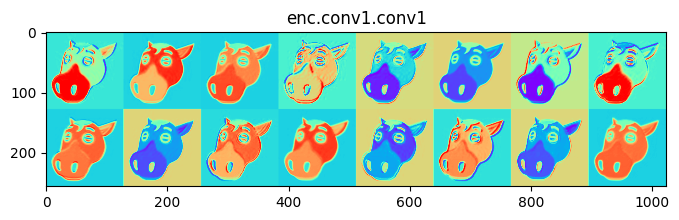

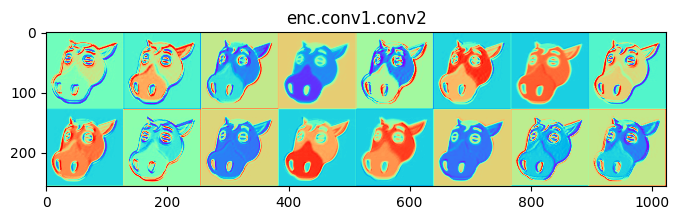

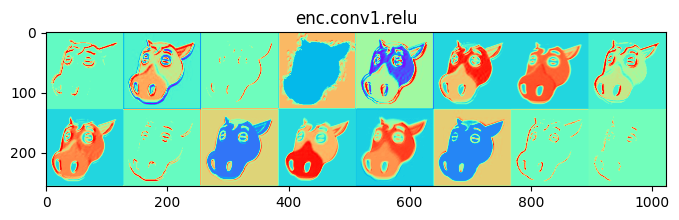

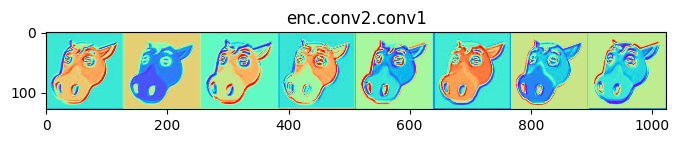

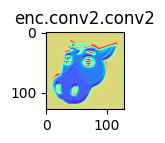

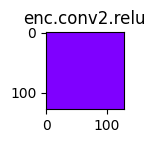

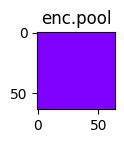

In [ ]:
# activation 시각화
for layer_name, layer_activation in zip(layer_name_lst ,activations) :

    img_per_row = 8
    n_features = layer_activation.shape[0]
    size = layer_activation.shape[1]

    n_cols = n_features // img_per_row
    if (n_cols == 0) & (n_features > 0):
        n_cols = 1
        display_grid = np.zeros((size*n_cols, n_features*size))
    else:
        display_grid = np.zeros((size*n_cols, img_per_row*size))

    count = n_features

    isRepeat = True
    while(isRepeat):
        for col in range(n_cols):
            if count == 0:
                    isRepeat = False
                    break
            for row in range(img_per_row):
                if count == 0:
                    isRepeat = False
                    break
                channel_image = layer_activation[col*img_per_row+row,:,:]
                channel_image = channel_image.cpu().detach().numpy()
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image +=128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col*size: (col+1)*size,
                                    row*size: (row+1)*size] = channel_image

                count -= 1


        isRepeat = False

    if n_features > 0 :
        scale = 1. / size
        if display_grid.shape[0] == 0:
            plt.figure(figsize=(
                scale*display_grid.shape[1], scale*display_grid.shape[0]
            ))
        else:
            plt.figure(figsize=(
                scale*display_grid.shape[1], scale*display_grid.shape[0]
            ))

        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='rainbow')

In [ ]:
# 인코더를 이용하여 특징 벡터 추출
index_lst = []
out_features = 1024

for num, data in enumerate(input_lst):
    index = model.enc(data[:3].to(device))
    index = index.view(1, -1)

    in_features = index.shape[1]
    index = nn.Linear(in_features, out_features)(index.to('cpu'))

    index_lst.append(index)

In [ ]:
index_lst_numpy = np.array([t.cpu().squeeze().detach().numpy() for t in index_lst])

In [ ]:
index_lst_numpy.shape

(380, 1024)

In [ ]:
np.save('animal_data_autoencoder.npy', index_lst_numpy)

In [ ]:
index_lst = np.load('animal_data_autoencoder.npy', allow_pickle=True)
index_lst.shape

(380, 1024)

In [ ]:
# 인덱스 추가하기
Index = faiss.IndexFlatL2(index_lst.shape[1])
print(Index.is_trained)		# True
Index.add(index_lst)
print(Index.ntotal)

True
380


In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

### Inference

#### 얼굴 클로즈업

In [ ]:
# return으로 PIL 타입의 이미지 반환
def crop_face(img_path = "query_images/송가인.png"):

    faces = RetinaFace.extract_faces(img_path = img_path, align = True)

    # face를 찾지 못하면 원본 이미지를 사용한다.
    if len(faces) == 0:
        face = Image.open(img_path)
    else:
        face = faces[0]
        face = Image.fromarray(face)

    return face

#### 유사도 계산하기
Faiss 알고리즘 사용

In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/인공지능 학원/프로젝트/이미지/만동숲'

In [ ]:
# 알파 블렌딩
def show_blending_image(src1, src2):
    alpha = 0.0

    fig, axes = plt.subplots(1, 6, figsize=(20, 20))

    for i in range(6):
        beta = 1.0 - alpha

        src = cv2.addWeighted(src2, alpha, src1, beta, 0)
        alpha += 0.2
        axes[i].imshow(src)
        axes[i].axis('off')

    return src

In [ ]:
tmp = cv2.resize(np.array(face), dsize=(128,128))
tmp.shape

(128, 128, 3)

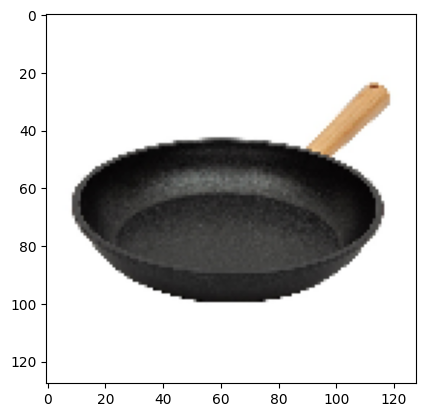

In [ ]:
plt.imshow(tmp)

(128, 128, 3)
(128, 128, 3)


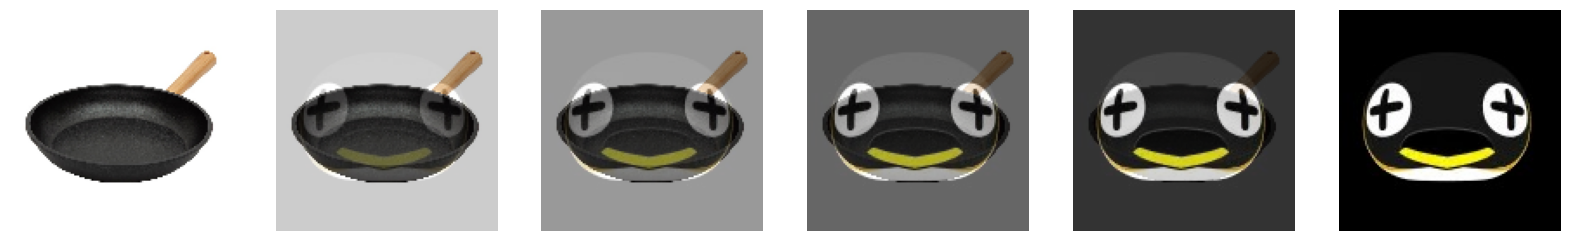

In [ ]:
#src1 = np.array(face)
src2 = np.array(result[0])

print(tmp.shape)
print(src2.shape)

src = show_blending_image(tmp, src2)

#### 새로운 이미지 들어왔을 때 유사도 계산하기

In [ ]:
model = CAE().to(device)
optim = Adam(params=model.parameters())

# 저장한 모델 불러오기
load_data = torch.load("model_autoencoder/ae_fine-tunning_2.pt")
# 모델 로드
model.load_state_dict(load_data['model'])
# 옵티마이저 로드
optim.load_state_dict(load_data['optimizer'])

In [ ]:
# gpu 사용 가능시에 cuda 선택
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model = model.to(device)

cuda


In [ ]:
tf_toTensor = ToTensor()

input_dir = "query_images/"
file_name = '송가인.png'
img_path = input_dir + file_name
# face = Image.open(input_dir + file_name)

face = crop_face(img_path)

input = tf_toTensor(face)

with torch.no_grad():
    if input.shape[0] == 4:
        input = input[:3]
    latent_vector = model.enc(input.to(device))
    latent_vector = latent_vector.view(1, -1)

    in_features = latent_vector.shape[1]
    latent_vector = nn.Linear(in_features, out_features)(latent_vector.to('cpu'))

In [ ]:
latent_vector.shape

torch.Size([1, 1024])

In [ ]:
distances, indexes = Index.search(index_lst[:3], 1)

In [ ]:
distances, indexes = Index.search(latent_vector, 1)

print('distances:', distances)
print('indexes[0]:', indexes[0])

distances: [[0.5026615]]
indexes[0]: [6]


In [ ]:
def get_result(latent_vector, k=3):
    distances, indexes = Index.search(latent_vector, k)

    print('distances:', distances)
    print('indexes[0]:', indexes[0])

    result = []

    for idx in indexes[0]:
        file_name = file_name_lst[idx]
        print(file_name)

        embedding_img_dir = "주민이미지/"
        input = Image.open(embedding_img_dir + file_name)
        display(input)

        result.append(input)

    return result

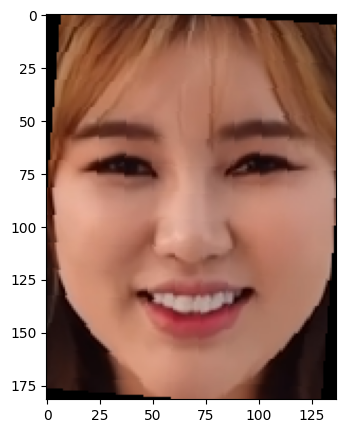

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(face)
plt.show()

distances: [[0.5026615 0.5091342 0.5117651]]
indexes[0]: [  6 120 221]
horse/horse_1.jpg


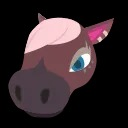

tiger/tiger_1.jpg


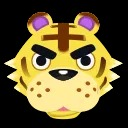

eagle/eagle_5.jpg


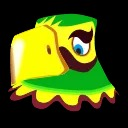

In [ ]:
result = get_result(latent_vector)

#### 누끼제거 (사용X)

In [ ]:
!pip install rembg

In [ ]:
from rembg import remove
from PIL import Image

In [ ]:
input_dir = "query_images/"

input = Image.open(input_dir+'송가인.png')
output = remove(input)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 128GB/s]


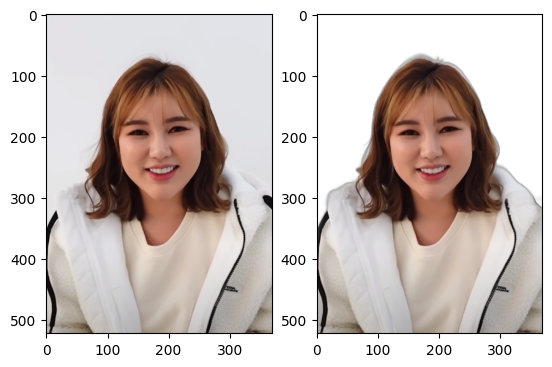

In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.imshow(input)

plt.subplot(1,2,2)
plt.imshow(output)

#### 얼굴만 잘라주는 라이브러리 사용 - autocrop (사용X)

In [ ]:
!pip install autocrop

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.0/159.0 kB 6.2 MB/s eta 0:00:00


In [ ]:
from autocrop import Cropper

cropper = Cropper()
cropped_array = cropper.crop(input_dir+'송가인.png')

In [ ]:
crop_image = Image.fromarray(cropped_array)

In [ ]:
crop_image.size

(500, 500)

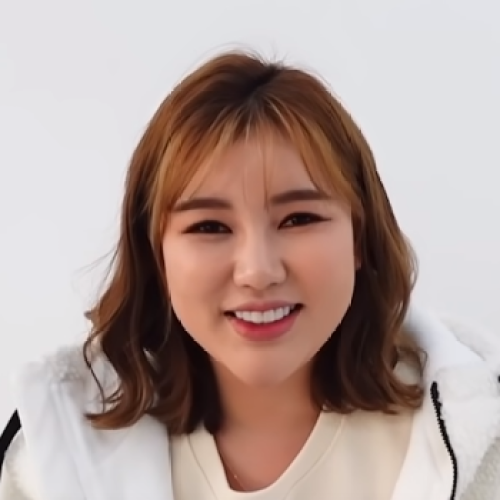

In [ ]:
crop_image

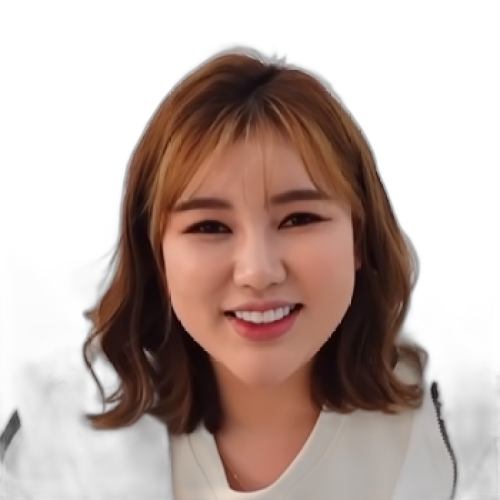

In [ ]:
crop_img_output = remove(crop_image)
crop_img_output